In [1]:
from transformer import Transformer
import pandas as pd
import numpy as np
import tqdm
import re
import torch 
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.input import AffineInputTransform
import matplotlib.pyplot as plt

<h2>Loading Split Data</h2>

In [2]:
####Training Set #####
# Load the CSV file
path = './../../experimental_data/'
training_set_df = pd.read_csv(path + 'training_set_1.csv')
test_set_df = pd.read_csv(path + '/test_set_1.csv')

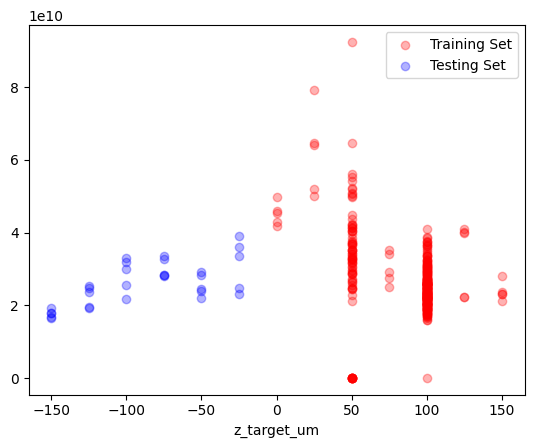

In [3]:
plt.figure()

plt.scatter(training_set_df['z_target_um'].values,
           training_set_df['n_protons'].values, c='r', alpha=0.3, label='Training Set')
plt.scatter(  test_set_df['z_target_um'].values,
           test_set_df['n_protons'].values, c='b', alpha=0.3, label='Testing Set')
plt.xlabel('z_target_um')
plt.legend()

# Visualizing Split Datasets

<Figure size 640x480 with 0 Axes>

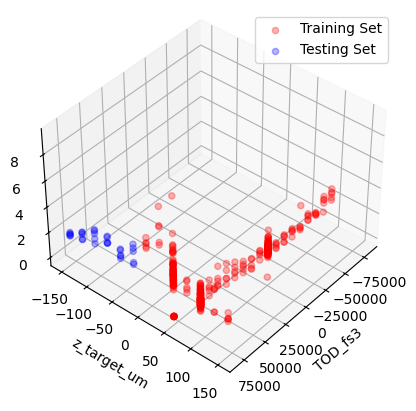

In [4]:
plt.clf()
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( training_set_df['TOD_fs3'], training_set_df['z_target_um'],
           training_set_df['n_protons'], c='r', alpha=0.3, label='Training Set')
ax.scatter( test_set_df['TOD_fs3'], test_set_df['z_target_um'],
           test_set_df['n_protons'], c='b', alpha=0.3, label='Testing Set')
ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel('TOD_fs3')
plt.ylabel('z_target_um')
plt.legend()

<h2>Normalizing Data</h2>

In [5]:
# Define the input and output normalizations, based on the training set
X = torch.tensor(training_set_df[['z_target_um', 'TOD_fs3']].values, dtype=torch.float64)
input_transform = AffineInputTransform(2, coefficient=X.std(axis=0), offset=X.mean(axis=0))
y = torch.tensor(training_set_df['n_protons'].values, dtype=torch.float64).reshape(-1,1)
output_transform = AffineInputTransform( 1, coefficient=y.std(axis=0), offset=y.mean(axis=0))

In [6]:
# Apply normalization to the training and test sets
norm_training_set_df = training_set_df.copy()
norm_training_set_df[['z_target_um', 'TOD_fs3']] = input_transform( torch.tensor( training_set_df[['z_target_um', 'TOD_fs3']].values ) )
norm_training_set_df[['n_protons']] = output_transform( torch.tensor( training_set_df[['n_protons']].values.reshape(-1,1) ) )

norm_test_set_df = test_set_df.copy()
norm_test_set_df[['z_target_um', 'TOD_fs3']] = input_transform( torch.tensor( test_set_df[['z_target_um', 'TOD_fs3']].values ) )
norm_test_set_df[['n_protons']] = output_transform( torch.tensor( test_set_df[['n_protons']].values.reshape(-1,1) ) )

<h2>Visualizing Normalized Data</h2>

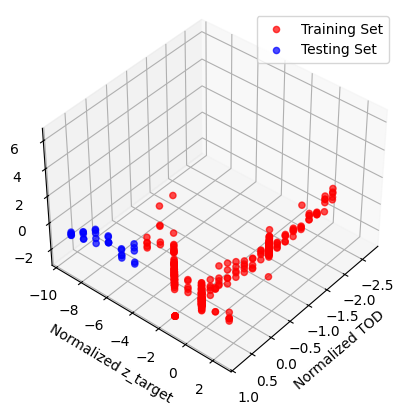

In [7]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter( norm_training_set_df['TOD_fs3'], norm_training_set_df['z_target_um'],
           norm_training_set_df['n_protons'], c='r', alpha=0.7, label='Training Set')
ax.scatter( norm_test_set_df['TOD_fs3'], norm_test_set_df['z_target_um'],
           norm_test_set_df['n_protons'], c='b', alpha=0.7, label='Testing Set')
ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized z_target')
ax.set_zlabel('Normalized n_rotons')

# Add legend
ax.legend()
# Show plot
plt.show()

<h1> Defining the Guassain Process & Training </h1>

In [8]:
# Extract the normalized training and test sets
norm_z_train_set = torch.tensor(norm_training_set_df['z_target_um'].values.reshape(-1,1), dtype=torch.float64)
norm_TOD_train_set = torch.tensor(norm_training_set_df['TOD_fs3'].values.reshape(-1,1), dtype=torch.float64)
norm_protons_train_set = torch.tensor(norm_training_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float64)
norm_z_test_set = torch.tensor(norm_test_set_df['z_target_um'].values.reshape(-1,1), dtype=torch.float64)
norm_TOD_test_set = torch.tensor(norm_test_set_df['TOD_fs3'].values.reshape(-1,1), dtype=torch.float64)
norm_protons_test_set = torch.tensor(norm_test_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float64)


train_x = torch.cat([norm_z_train_set, norm_TOD_train_set], dim=1).detach()
train_y = norm_protons_train_set

test_x = torch.cat([norm_z_test_set, norm_TOD_test_set], dim=1).detach()
test_y = norm_protons_test_set

In [13]:
gp_model = SingleTaskGP(train_x, train_y)
# train model hyperparameters minimizing negative-Log-Marginal-Likelihood
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)

/opt/anaconda3/envs/lume-model-dev/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

<h1> Evaluating The Model </h1>

In [10]:
def eval_mode(model, x_data, y_data):
    """
    Perform predictions using the provided model and likelihood on the given input data.

    Parameters:
    - model: The trained model.
    - likelihood: The likelihood function associated with the model.
    - x_data: The input data for which predictions are to be made.

    Returns:
    - mean_prediction: The mean predictions from the model.
    - lower_bound: The lower bound of the confidence interval.
    - upper_bound: The upper bound of the confidence interval.
    """
    inputs = torch.cat([x_data, y_data], dim=1)
    #model.eval()
    model.likelihood.eval()

    with torch.no_grad():
        #predictions = model.likelihood(model(inputs))
        predictions =  model.posterior(inputs)
        mean_prediction = predictions.mean  # Mean prediction
        lower_bound, upper_bound = predictions.confidence_region()  # Confidence interval

    return mean_prediction, lower_bound, upper_bound

<h1> Visualizing predictions </h1>

In [15]:
z_target_test_array = torch.arange(-10, 3, 0.1).unsqueeze(1)
tod_test_array = torch.full((130,), 1).unsqueeze(1) 
array_mean_prediction, train_lower_set, train_upper_set = eval_mode(gp_model, z_target_test_array, tod_test_array)

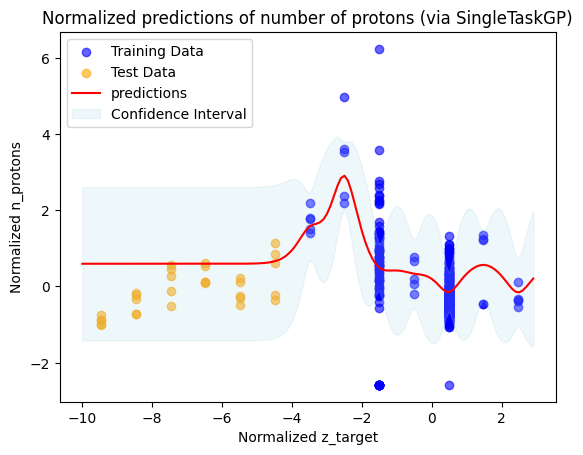

In [16]:
plt.figure()

show_confidence_interval = 'True'

# Scatter plot of the actual test data
plt.scatter(norm_z_train_set.numpy(), norm_protons_train_set.numpy(), c='blue', label='Training Data',alpha=0.6)
plt.scatter(norm_z_test_set.numpy(), norm_protons_test_set.numpy(), c='orange', label='Test Data',alpha=0.6)
plt.plot(z_target_test_array.numpy(),array_mean_prediction.numpy(), label='predictions', c='red' )

plt.xlabel('Normalized z_target')
plt.ylabel('Normalized n_protons')
plt.title("Normalized predictions of number of protons (via SingleTaskGP)")


if show_confidence_interval == 'True':
    plt.fill_between(z_target_test_array.squeeze().numpy(), train_lower_set, train_upper_set, color='lightblue', alpha=0.2, label='Confidence Interval')
plt.legend()
# Save the plot
plt.savefig("./SingleGP_predictions.png", dpi=200)
plt.show()

In [17]:
pwd

'/Users/oshapoval/workspace/2024_IFE-superfacility_version_2/2024_IFE-superfacility/ml/GP_training'